<a href="https://colab.research.google.com/github/dswh/lil_nlp_with_tensorflow/blob/main/03_04_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Review Classifier
This notebook serves to implement and explore LSTM and Convolution model over the new Yelp review dataset.

In [1]:
##import the required libraries and APIs
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.9.2


## Downloading the TensorFlow `yelp_popularity_review` dataset

> Make sure tensorflow_datasets is installed

In [2]:
##load the yelp reviews dataset
data, info = tfds.load("yelp_polarity_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/560000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incomplete39PY1D/yelp_polarity_reviews-train.t…

Generating test examples...:   0%|          | 0/38000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0.incomplete39PY1D/yelp_polarity_reviews-test.tf…

Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/0.2.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = data['train'], data['test']

train_sentences = []
test_sentences = []

train_labels = []
test_labels = []

In [4]:
for sent, label in train_data:
    train_sentences.append(str(sent.numpy().decode('utf8')))
    train_labels.append(label.numpy())

for sent, label in test_data:
    test_sentences.append(str(sent.numpy().decode('utf8')))
    test_labels.append(label.numpy())


train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [5]:
##define the parameters for tokenizing and padding
vocab_size = 10000
embedding_dim = 32
max_length = 120
padding_type = 'post'
trunc_type='post'
oov_tok = "<OOV>"

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seqs,maxlen=max_length, truncating=trunc_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

## Explore the LSTM & ANN model with the following layers:
1. Embedding layer
2. Trying two bidirectional LSTM layers.
3. Dense layer with 24 nodes
4. Output Dense layer with `sigmoid` activation 

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 120, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 653,377
Trainable params: 653,377
Non-trai

In [9]:
num_epochs = 10
history = model.fit(
    train_padded, 
    train_labels, 
    epochs=num_epochs, 
    validation_data=(test_padded, test_labels)
    )

Epoch 1/10
17500/17500 [==============================] - 406s 23ms/step - loss: 0.2043 - accuracy: 0.9167 - val_loss: 0.1506 - val_accuracy: 0.9406
Epoch 2/10
17500/17500 [==============================] - 393s 22ms/step - loss: 0.1485 - accuracy: 0.9413 - val_loss: 0.1316 - val_accuracy: 0.9496
Epoch 3/10
17500/17500 [==============================] - 389s 22ms/step - loss: 0.1263 - accuracy: 0.9511 - val_loss: 0.1367 - val_accuracy: 0.9495
Epoch 4/10
17500/17500 [==============================] - 397s 23ms/step - loss: 0.1087 - accuracy: 0.9586 - val_loss: 0.1309 - val_accuracy: 0.9499
Epoch 5/10
17500/17500 [==============================] - 387s 22ms/step - loss: 0.0923 - accuracy: 0.9656 - val_loss: 0.1445 - val_accuracy: 0.9474
Epoch 6/10
17500/17500 [==============================] - 388s 22ms/step - loss: 0.0762 - accuracy: 0.9721 - val_loss: 0.1505 - val_accuracy: 0.9470
Epoch 7/10
17500/17500 [==============================] - 393s 22ms/step - loss: 0.0623 - accuracy: 0.9775

## Visualise the accuracy and loss

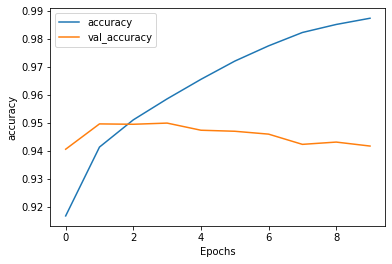

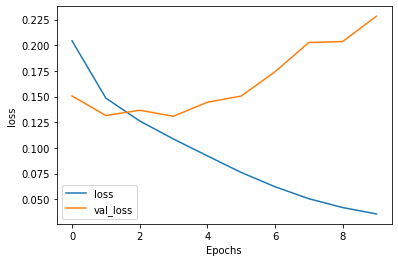

In [10]:
import matplotlib.pyplot as plt


def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

## Classify new reviews

In [11]:
sentence = ["the restaurant served a delicious pasta", "the restaurant didn't have a decent ambience"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 3s 3s/step
[[0.58568305]
 [0.4102531 ]]
